In [74]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [75]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [76]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000,)
(10000, 28, 28)


In [77]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(60000, 784)
(60000,)
(10000,)
(10000, 784)


In [78]:
Y_train = np.zeros((len(y_train),10))
for i in range(len(y_train)):
    Y_train[i,y_train[i]] = 1

Y_test = np.zeros((len(y_test),10))
for j in range(len(y_test)):
    Y_test[j,y_test[j]] = 1

In [80]:
print(x_train.shape)
print(Y_train.shape)
print(x_test.shape)
print(Y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


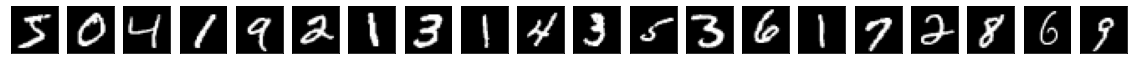

In [81]:
n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

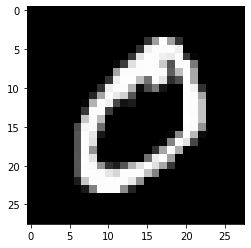

In [82]:
XX_train = x_train.astype('float32') / 255.
XX_test = x_test.astype('float32') / 255.
plt.imshow(XX_train[1].reshape(28,28))

In [83]:
XX_train = XX_train.T
XX_test = XX_test.T
Y_train = Y_train.T
Y_test = Y_test.T
# Y_train = Y_train.reshape(1,-1)
# Y_test = Y_test.reshape(1,-1)
print(XX_train.shape)
print(Y_train.shape)
print(XX_test.shape)
print(Y_test.shape)

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)


In [84]:
print(XX_test.shape)

(784, 10000)


In [85]:
def softmax(Z):
	expZ = np.exp(Z - np.max(Z))
	return expZ / expZ.sum(axis=0, keepdims=True)

In [ ]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A

In [88]:
def deep_initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])# *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [89]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W,A_prev) + b
    linear_cache = (A_prev, W, b)
        
    if activation == "softmax":    
        A = softmax(Z)
    elif activation == "relu":
        A = relu(Z)
    
    cache = (linear_cache, Z)
    return A, cache  

In [90]:
def deep_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)
    return AL, caches

In [91]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m)*np.sum(Y * np.log(AL))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

In [92]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [94]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

In [95]:
def softmax_backward(AL,Y,cache):
    Z = cache
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ


In [96]:
def linear_activation_backward(Y,AL,dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "softmax":
        dZ = softmax_backward(AL,Y,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [97]:
def deep_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(Y,AL,dAL, current_cache, activation = "softmax")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(Y,AL,grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads  

In [98]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [99]:
def deep_layer_model(X, Y, layers_dims, learning_rate, num_iterations): #lr was 0.009
    costs = []
    parameters = deep_initialize_parameters(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = deep_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = deep_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        costs.append(cost)
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    return parameters, costs

In [100]:
layers_dims = [XX_train.shape[0], 256, 64,32,10]
print(len(layers_dims))
par, costs = deep_layer_model(XX_train, Y_train, layers_dims, learning_rate=0.1, num_iterations=1000)


5
Cost after iteration 0: 2.318813
Cost after iteration 100: 0.549601
Cost after iteration 200: 0.334907
Cost after iteration 300: 0.278178
Cost after iteration 400: 0.237688
Cost after iteration 500: 0.208247
Cost after iteration 600: 0.184186
Cost after iteration 700: 0.164562
Cost after iteration 800: 0.148282
Cost after iteration 900: 0.134593


In [117]:
def predict(X,Y,parameters):
    probs, caches = deep_model_forward(X, parameters) 
    y_hat = np.argmax(probs, axis=0)
    Y = np.argmax(Y, axis=0)
    accuracy = (y_hat == Y).mean()
    return accuracy * 100


In [118]:
print("Train Accuracy: ",predict(XX_train,Y_train,par))

Train Accuracy:  96.47833333333334


In [120]:
print("Test Accuracy: ",predict(XX_test, Y_test, par))

Test Accuracy:  96.07


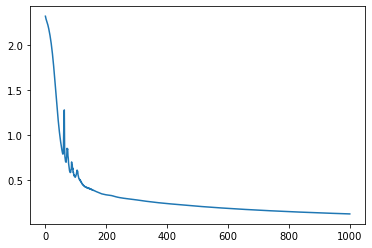

In [121]:
plt.plot(range(len(costs)),costs)